### Bias Regularization
We optimizer bilevel optimization problem
$$f(\lambda) = \frac{1}{2} ||X'w(\lambda) -y'||^2 \quad \text{(outer level)}$$
$$w(\lambda) = \arg\min_w \frac{1}{2}||Xw - y||^2 + \frac{\beta}{2}||w - \lambda|| \quad \text{(inner level)}$$


In [11]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
from model import BaseHyperOptModel
from hyper_opt import FixedPointHyperOptimizer

import matplotlib.pyplot as plt 
%matplotlib inline

Create main model

In [5]:
class LinearModel(nn.Module):

    def __init__(self, n_dims):
        super().__init__()
        self.w = nn.Parameter(torch.randn(n_dims, 1))
    
    def forward(self, x):
        return x @ self.w

Create hyperparameter model

In [66]:
class BiaseRegularization(BaseHyperOptModel):

    def __init__(self, n_dims, beta=1.):
        network = LinearModel(n_dims)
        criterion = nn.MSELoss(reduction='mean')
        super().__init__(network, criterion)

        self.ell = nn.Parameter(torch.zeros(n_dims, 1))
        self.beta = beta
    
    @property
    def hyper_parameters(self):
        return [self.ell]
    
    def regularizer(self):
        return 0.5 * self.beta * torch.norm(self.network.w - self.ell)**2
    

Create data

In [70]:
n, d = 2000, 20
w_oracle, bias_oracle = torch.randn(d, 1), torch.ones(d,1)  # set according to the paper
x = torch.randn(n,d)
y = x @ (w_oracle + bias_oracle) + 0.1 * torch.randn(n, 1)

x_train, y_train = x[:n//2], y[:n//2]
x_val, y_val = x[n//2:], y[n//2:]

n_test = 1000
x_test = torch.randn(n_test, d)
y_test = x_test @ (w_oracle + bias_oracle)

In [77]:
model = BiaseRegularization(n_dims=d)

w_optimizer = torch.optim.SGD(model.parameters, lr=0.1)
hyper_optimizer = FixedPointHyperOptimizer(model.parameters, model.hyper_parameters, default=dict(lr=1.), stochastic=False, use_gauss_newton=False)
hyper_optimizer.set_kwargs(inner_lr=0.1, K=20)

def train_loss_func():
    return model.train_loss(x_train, y_train)




In [78]:
val_losses = []
test_losses = []
hyperparam_hist = []

n_iter = 100
T = 10

for i in range(n_iter):

    # inner optimizer
    for t in range(T):
        w_optimizer.zero_grad()
        loss, _ = model.train_loss(x_train, y_train)
        loss.backward()
        w_optimizer.step()
    
    val_loss = model.validation_loss(x_val, y_val)
    hyper_optimizer.step(train_loss_func, val_loss)

    if i % 10 == 0:
        print(f"Iter {i} \t Val loss: {val_loss.item():.3f}")
        test_loss = model.validation_loss(x_test, y_test)
        test_losses.append(test_loss.item())
        hyperparam_hist.append(model.hyper_parameters[0].detach().clone().numpy())
    val_losses.append(val_loss.item())

Iter 0 	 Val loss: 4.341
Iter 10 	 Val loss: 0.035
Iter 20 	 Val loss: 0.011
Iter 30 	 Val loss: 0.010
Iter 40 	 Val loss: 0.010
Iter 50 	 Val loss: 0.010
Iter 60 	 Val loss: 0.010
Iter 70 	 Val loss: 0.010
Iter 80 	 Val loss: 0.010
Iter 90 	 Val loss: 0.010


Text(0.5, 0, 'outer steps')

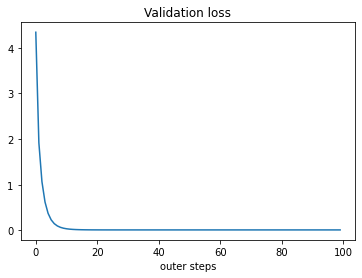

In [79]:
plt.plot(val_losses)
plt.title("Validation loss")
plt.xlabel("outer steps")

Text(0.5, 1.0, 'Test loss')

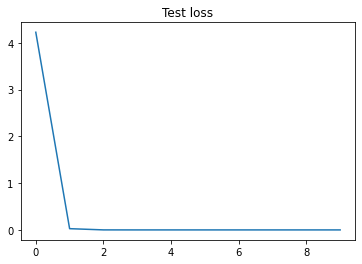

In [80]:
plt.plot(test_losses)
plt.title("Test loss")

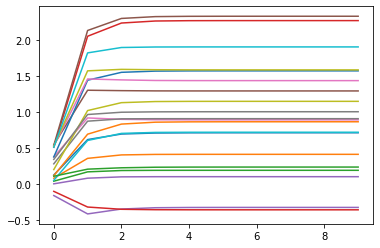

In [81]:
hyperparam_hist = [x.squeeze() for x in hyperparam_hist]
plt.plot(hyperparam_hist)